In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as celery
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [2]:
xo.__version__

'0.2.6'

In [3]:
np.random.seed(42)

#### generate RVs on a dense grid of times:

In [4]:
log_S0 = -3.0
log_Q = 8.1
log_omega0 = -3.9

In [5]:
kernel_onemode = celery.terms.SHOTerm(log_S0, log_Q, log_omega0)

In [6]:
nights_per_year = 60
start_ts = np.arange(1,1+nights_per_year) * 3600. * 24. # nightly on consecutive nights
start_ts += np.random.randint(-60, 60, nights_per_year)*60. # random perturbation of up to an hour before/after
dt = 30. # grid spacing within a night (s)
N = 2. * 3600. / dt # 1 hours each night
t_all = np.ravel([np.arange(N) * dt + tt - 900. for tt in start_ts])

In [7]:
gp = celery.GP(kernel_onemode)
gp.compute(t_all)
y_all = gp.sample()

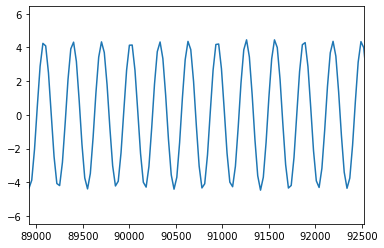

In [8]:
plt.plot(t_all, y_all)
plt.xlim([start_ts[0], start_ts[0]+3600.]);

#### bin down to simulate longer exposures:

In [9]:
from scipy.interpolate import interp1d

In [10]:
t = []
y = []

exp_time = 3. * 60.
n_exp = 10

for st in start_ts:
    inds = (t_all > st - 900.) & (t_all < st + exp_time+n_exp + 3600.)
    interp = interp1d(t_all[inds], y_all[inds], kind='cubic')
    tiny = 0.1 # 100 ms
    for n in range(n_exp):
        stt = st + n*exp_time # start time for this exposure, assumes no read time
        fine_ts = np.arange(stt, stt+exp_time, tiny) # fine grid
        fine_rvs = interp(fine_ts)
        avg_rv = np.sum(fine_rvs)/len(fine_rvs) # technically incorrect but close enough
        y.append(avg_rv)
        t.append(stt + exp_time/2.)

t = np.array(t)
y = np.array(y)

In [11]:
# add photon noise:
noise_amp = 0.5
yerr = np.zeros_like(y) + noise_amp
y += np.random.normal(0., noise_amp, len(y))

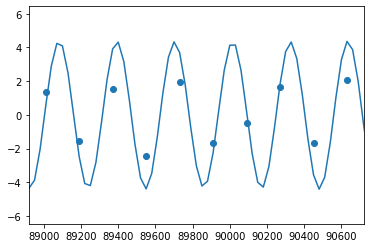

In [12]:
plt.plot(t_all, y_all)
plt.scatter(t,y)
plt.xlim([start_ts[0], start_ts[0]+1800.]);

#### model with an integrated kernel:

In [13]:
with pm.Model() as model:
    kernel = terms.SHOTerm(log_S0=log_S0, log_w0=log_omega0, log_Q=log_Q)
    kernel_int = terms.IntegratedTerm(kernel, exp_time)
    gp = GP(kernel_int, t, yerr ** 2)
    gp.condition(y)
    mu, var = xo.eval_in_model(gp.predict(t_all, return_var=True))
    sd = np.sqrt(var)
    y_pred = xo.eval_in_model(gp.predict(t))


You can find the C code in this temporary file: /var/folders/7k/xdffjd2n3pn14hm4drwjtq1c00014q/T/theano_compilation_error_s8fj3y1j


Exception: ("Compilation failed (return status=1): /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:500:27: error: non-constant-expression cannot be narrowed from type 'npy_intp' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing].     int init_totals[2] = {V5_n0, V3_n1};.                           ^~~~~. /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:500:27: note: insert an explicit cast to silence this issue.     int init_totals[2] = {V5_n0, V3_n1};.                           ^~~~~.                           static_cast<int>( ). /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:500:34: error: non-constant-expression cannot be narrowed from type 'npy_intp' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing].     int init_totals[2] = {V5_n0, V3_n1};.                                  ^~~~~. /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:500:34: note: insert an explicit cast to silence this issue.     int init_totals[2] = {V5_n0, V3_n1};.                                  ^~~~~.                                  static_cast<int>( ). /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:512:12: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing].         0, V3_stride1, .            ^~~~~~~~~~. /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:512:12: note: insert an explicit cast to silence this issue.         0, V3_stride1, .            ^~~~~~~~~~.            static_cast<int>( ). /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:513:1: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. V5_stride0, 0, . ^~~~~~~~~~. /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:513:1: note: insert an explicit cast to silence this issue. V5_stride0, 0, . ^~~~~~~~~~. static_cast<int>( ). /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:514:1: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. V1_stride0, V1_stride1. ^~~~~~~~~~. /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:514:1: note: insert an explicit cast to silence this issue. V1_stride0, V1_stride1. ^~~~~~~~~~. static_cast<int>( ). /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:514:13: error: non-constant-expression cannot be narrowed from type 'ssize_t' (aka 'long') to 'int' in initializer list [-Wc++11-narrowing]. V1_stride0, V1_stride1.             ^~~~~~~~~~. /Users/mbedell/.theano/compiledir_Darwin-19.4.0-x86_64-i386-64bit-i386-3.7.7-64/tmp57iu5_3f/mod.cpp:514:13: note: insert an explicit cast to silence this issue. V1_stride0, V1_stride1.             ^~~~~~~~~~.             static_cast<int>( ). 6 errors generated.. ", '[Elemwise{add,no_inplace}(<TensorType(float64, row)>, <TensorType(float64, col)>)]')

In [ ]:
plt.plot(t_all, y_all)
plt.scatter(t,y)
art = plt.fill_between(t_all, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(t_all, mu, color="C1")
plt.xlim([start_ts[0], start_ts[0]+1800.]);